<a href="https://colab.research.google.com/github/aakashpaul-2/RNN-Projects/blob/main/LSTM_MNIST.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

In [ ]:
'''
Using LSTM (Pytorch) to identify the MNIST dataset
'''

In [ ]:
import torch
import torch.nn as nn
import numpy as np
import matplotlib.pyplot as plt
import torchvision
import torchvision.transforms as transforms
from datetime import datetime

In [ ]:
train_dataset = torchvision.datasets.MNIST(
    root='.',
    train=True,
    transform=transforms.ToTensor(),
    download=True)

Failed to download (trying next):
HTTP Error 503: Service Unavailable




Extracting ./MNIST/raw/train-images-idx3-ubyte.gz to ./MNIST/raw




Extracting ./MNIST/raw/train-labels-idx1-ubyte.gz to ./MNIST/raw

Failed to download (trying next):
HTTP Error 503: Service Unavailable




Extracting ./MNIST/raw/t10k-images-idx3-ubyte.gz to ./MNIST/raw




Extracting ./MNIST/raw/t10k-labels-idx1-ubyte.gz to ./MNIST/raw

Processing...
Done!


/usr/local/lib/python3.7/dist-packages/torchvision/datasets/mnist.py:502: UserWarning: The given NumPy array is not writeable, and PyTorch does not support non-writeable tensors. This means you can write to the underlying (supposedly non-writeable) NumPy array using the tensor. You may want to copy the array to protect its data or make it writeable before converting it to a tensor. This type of warning will be suppressed for the rest of this program. (Triggered internally at  /pytorch/torch/csrc/utils/tensor_numpy.cpp:143.)
  return torch.from_numpy(parsed.astype(m[2], copy=False)).view(*s)


In [ ]:
test_dataset = torchvision.datasets.MNIST(
    root='.',
    train=False,
    transform=transforms.ToTensor(),
    download=True)

In [ ]:
# number of classes
K = len(set(train_dataset.targets.numpy()))
print("number of classes:", K)

number of classes: 10


In [ ]:
### Define RNN
class RNN(nn.Module):

  def __init__(self, n_inputs, n_hidden, n_rnnlayers, n_outputs):
    super(RNN, self).__init__()
    self.D = n_inputs
    self.M = n_hidden
    self.K = n_outputs
    self.L = n_rnnlayers

    # batch_first=True - applies the convention that data will be of shape: (num_samples, sequence_length, num_features)
    self.rnn = nn.LSTM(
        input_size=self.D,
        hidden_size=self.M,
        num_layers=self.L,
        batch_first=True)
    self.fc =nn.Linear(self.M, self.K)
  
  def forward(self, X):
    # initial hidden states
    h0 = torch.zeros(self.L, X.size(0), self.M).to(device)
    c0 = torch.zeros(self.L, X.size(0), self.M).to(device)

    # out is of size (N, T, M)
    # 2nd return value is hidden states at each hidden layer not needed
    out, _ = self.rnn(X, (h0, c0))

    # h(T) at the final time step
    out = self.fc(out[:, -1, :])
    return out

In [ ]:
# automatically generates batches in the training loop and takes care of shuffling

batch_size = 128
train_loader = torch.utils.data.DataLoader(dataset=train_dataset, 
                                           batch_size=batch_size, 
                                           shuffle=True)

test_loader = torch.utils.data.DataLoader(dataset=test_dataset, 
                                          batch_size=batch_size, 
                                          shuffle=False)

In [ ]:
train_loader

In [ ]:
# A function to encapsulate the training loop
def batch_gd(model, criterion, optimizer, train_loader, test_loader, epochs):
  train_losses = np.zeros(epochs)
  test_losses = np.zeros(epochs)

  for it in range(epochs):
    t0 = datetime.now()
    train_loss = []
    for inputs, targets in train_loader:
      # move data to GPU
      inputs, targets = inputs.to(device), targets.to(device)
      inputs = inputs.view(-1,28,28)
      # zero the parameter gradients
      optimizer.zero_grad()

      # Forward pass
      outputs = model(inputs)
      loss = criterion(outputs, targets)
        
      # Backward and optimize
      loss.backward()
      optimizer.step()

      train_loss.append(loss.item())

    # Get train loss and test loss
    train_loss = np.mean(train_loss) # a little misleading
    
    test_loss = []
    for inputs, targets in test_loader:
      inputs, targets = inputs.to(device), targets.to(device)
      inputs = inputs.view(-1,28,28)
      outputs = model(inputs)
      loss = criterion(outputs, targets)
      test_loss.append(loss.item())
    test_loss = np.mean(test_loss)

    # Save losses
    train_losses[it] = train_loss
    test_losses[it] = test_loss
    
    dt = datetime.now() - t0
    print(f'Epoch {it+1}/{epochs}, Train Loss: {train_loss:.4f}, \
      Test Loss: {test_loss:.4f}, Duration: {dt}')
  
  return train_losses, test_losses

In [ ]:
model = RNN(n_inputs=28, n_hidden=128, n_rnnlayers=2, n_outputs=10)
model.to(device)

RNN(
  (rnn): LSTM(28, 128, num_layers=2, batch_first=True)
  (fc): Linear(in_features=128, out_features=10, bias=True)
)

In [ ]:
device = torch.device("cuda:0" if torch.cuda.is_available() else "cpu")
print(device)
model.to(device)

cpu


RNN(
  (rnn): LSTM(28, 128, num_layers=2, batch_first=True)
  (fc): Linear(in_features=128, out_features=10, bias=True)
)

In [ ]:
# Loss and optimizer
criterion = nn.CrossEntropyLoss()
optimizer = torch.optim.Adam(model.parameters(), lr=0.001)

In [ ]:
train_losses, test_losses = batch_gd(
    model, criterion, optimizer, train_loader, test_loader, epochs=15)

Epoch 1/15, Train Loss: 0.5379,       Test Loss: 0.1490, Duration: 0:01:12.359144
Epoch 2/15, Train Loss: 0.1292,       Test Loss: 0.1004, Duration: 0:01:12.304828
Epoch 3/15, Train Loss: 0.0849,       Test Loss: 0.0763, Duration: 0:01:12.105123
Epoch 4/15, Train Loss: 0.0644,       Test Loss: 0.0696, Duration: 0:01:12.141440
Epoch 5/15, Train Loss: 0.0533,       Test Loss: 0.0564, Duration: 0:01:12.362830
Epoch 6/15, Train Loss: 0.0412,       Test Loss: 0.0448, Duration: 0:01:12.309555
Epoch 7/15, Train Loss: 0.0391,       Test Loss: 0.0464, Duration: 0:01:16.582613
Epoch 8/15, Train Loss: 0.0327,       Test Loss: 0.0404, Duration: 0:01:13.128815
Epoch 9/15, Train Loss: 0.0287,       Test Loss: 0.0396, Duration: 0:01:12.597567
Epoch 10/15, Train Loss: 0.0247,       Test Loss: 0.0389, Duration: 0:01:11.244526
Epoch 11/15, Train Loss: 0.0221,       Test Loss: 0.0368, Duration: 0:01:11.008145
Epoch 12/15, Train Loss: 0.0218,       Test Loss: 0.0452, Duration: 0:01:11.565376
Epoch 13/15, 

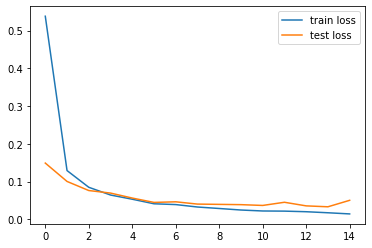

In [ ]:
plt.plot(train_losses, label='train loss')
plt.plot(test_losses, label='test loss')
plt.legend()
plt.show()

In [ ]:
n_correct = 0.
n_total = 0.
for inputs, targets in train_loader:
  # move data to GPU
  inputs, targets = inputs.to(device), targets.to(device)

  # reshape the input
  inputs = inputs.view(-1, 28, 28)

  # Forward pass
  outputs = model(inputs)

  # Get prediction
  # torch.max returns both max and argmax
  _, predictions = torch.max(outputs, 1)
  
  # update counts
  n_correct += (predictions == targets).sum().item()
  n_total += targets.shape[0]

train_acc = n_correct / n_total


n_correct = 0.
n_total = 0.
for inputs, targets in test_loader:
  # move data to GPU
  inputs, targets = inputs.to(device), targets.to(device)
  
  # reshape the input
  inputs = inputs.view(-1, 28, 28)

  # Forward pass
  outputs = model(inputs)

  # Get prediction
  # torch.max returns both max and argmax
  _, predictions = torch.max(outputs, 1)
  
  # update counts
  n_correct += (predictions == targets).sum().item()
  n_total += targets.shape[0]

test_acc = n_correct / n_total
print(f"Train acc: {train_acc:.4f}, Test acc: {test_acc:.4f}")

Train acc: 0.9929, Test acc: 0.9857
